In [1]:
### Structure
# Extract sample data from BigQuery
# Exploring data
# Quality control and other preprocessing
# Create ML datasets
# Verify that datasets exist
# Benchmark
# Benchmark on same dataset

In [35]:
# Extract sample data from BigQuery
# Import libraries
from google.cloud import bigquery
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shutil

In [38]:
# SQL query
sql = """
    SELECT
        pickup_datetime, 
        pickup_longitude, 
        pickup_latitude, 
        dropoff_longitude, 
        dropoff_latitude, 
        passenger_count, 
        trip_distance, 
        tolls_amount, 
        fare_amount, 
        total_amount 
    FROM `nyc-tlc.yellow.trips`
    LIMIT 10
"""

In [39]:
# Run a query
CREDS = 'arboreal-parser-228610-9d3cc71c229e.json'
client = bigquery.Client.from_service_account_json(json_credentials_path=CREDS)
trips = client.query(sql).to_dataframe()
trips

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
0,2015-04-17 08:07:24+00:00,-73.901932,40.764160,-73.902008,40.764130,5,0.0,0.0,0.0,0.0
1,2010-02-06 20:23:08+00:00,-73.795666,40.644648,-73.980812,40.764683,2,178.7,0.0,0.0,0.0
2,2010-02-02 23:17:55+00:00,-73.924135,40.752351,-73.924135,40.752351,1,0.0,0.0,0.0,0.0
3,2013-08-08 15:21:50+00:00,-74.000860,40.762344,-74.000997,40.762137,1,0.0,0.0,0.0,0.0
4,2010-02-18 12:29:13+00:00,-73.976301,40.732448,-73.976340,40.732448,1,0.0,0.0,0.0,0.0
5,2010-03-16 17:13:04+00:00,-73.971133,40.760423,-73.786367,40.638546,1,16.1,0.0,0.0,0.0
6,2010-03-04 04:25:37+00:00,-73.776251,40.645725,-73.776251,40.645725,1,0.0,0.0,0.0,0.0
7,2013-08-31 23:59:24+00:00,-73.995712,40.723319,-74.001071,40.727537,2,4.4,0.0,0.0,0.0
8,2015-04-12 05:38:51+00:00,-73.937500,40.758331,-73.937523,40.758335,1,0.0,0.0,0.0,0.0
9,2015-05-24 23:47:47+00:00,-73.990479,40.757786,-74.023338,40.759418,2,3.0,0.0,0.0,0.3


In [40]:
sql = """
    SELECT
        pickup_datetime,
        pickup_longitude,
        pickup_latitude,
        dropoff_longitude,
        dropoff_latitude,
        passenger_count,
        trip_distance,
        tolls_amount,
        fare_amount,
        total_amount
    FROM
        `nyc-tlc.yellow.trips`
    WHERE
        ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), 100000)) = 1
"""

In [41]:
trips = client.query(sql).to_dataframe()
trips[:10]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
0,2015-05-19 09:00:10+00:00,-73.945427,40.774059,-74.002724,40.742313,1,4.80,0.0,19.0,19.80
1,2009-09-16 20:45:23+00:00,-73.987603,40.728781,-73.998216,40.677855,1,6.10,0.0,16.9,17.40
2,2012-03-04 00:57:00+00:00,-74.004595,40.741882,-73.950250,40.787300,1,5.53,0.0,16.1,20.42
3,2013-01-29 05:21:00+00:00,-74.003900,40.717222,-73.955505,40.777727,2,7.62,0.0,22.5,28.10
4,2013-10-13 04:35:45+00:00,-73.998057,40.763300,-73.915878,40.832179,1,9.10,0.0,30.5,31.50
5,2009-01-23 05:49:07+00:00,-73.987462,40.760523,-73.978658,40.752389,1,1.00,0.0,5.4,5.40
6,2011-03-19 03:32:00+00:00,-73.977982,40.778760,-73.940377,40.723685,1,6.17,0.0,17.3,21.86
7,2014-04-11 00:16:56+00:00,-73.995064,40.721451,-74.038159,40.616236,2,11.10,0.0,31.5,41.50
8,2013-12-06 14:55:00+00:00,-74.012152,40.713567,-73.987077,40.750587,2,3.91,0.0,17.5,21.00
9,2010-05-22 12:30:55+00:00,-73.947361,40.775829,-73.993657,40.721529,2,5.70,0.0,17.7,18.20


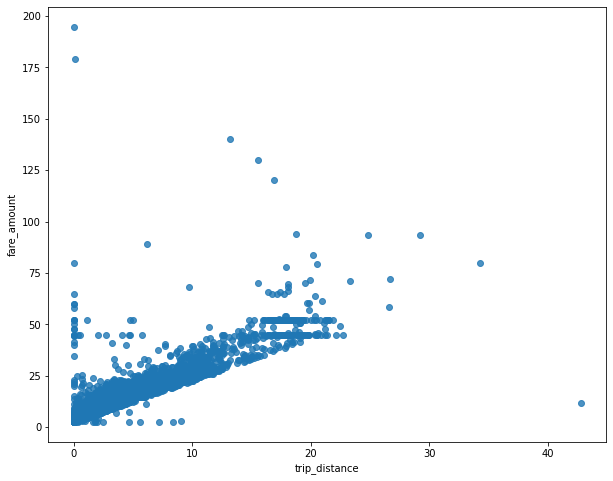

In [42]:
# Exploring data
ax = sns.regplot(x="trip_distance", y="fare_amount", fit_reg=False, ci=None, truncate=True, data=trips)
ax.figure.set_size_inches(10, 8)

In [43]:
# Modify the query to keep only trips longer than zero miles and fare amounts that are at least the minimum cab fare ($2.50)
sql = """
    SELECT
        pickup_datetime,
        pickup_longitude,
        pickup_latitude,
        dropoff_longitude,
        dropoff_latitude,
        passenger_count,
        trip_distance,
        tolls_amount,
        fare_amount,
        total_amount
    FROM
        `nyc-tlc.yellow.trips`
    WHERE
        ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), 100000)) = 1
        AND trip_distance > 0 AND fare_amount >= 2.5
"""

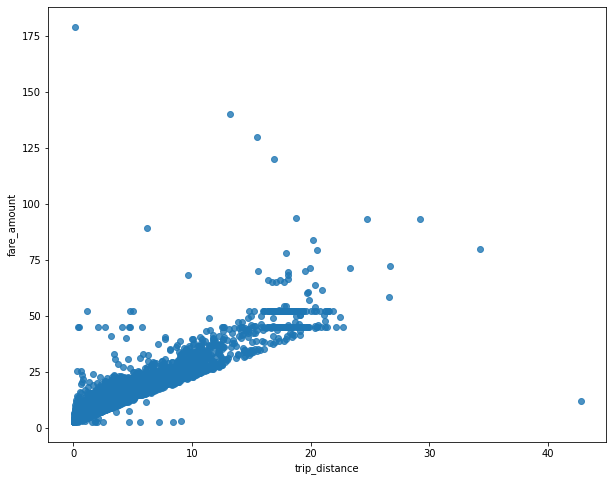

In [45]:
trips = client.query(sql).to_dataframe()
ax = sns.regplot(x="trip_distance", y="fare_amount", fit_reg=False, ci=None, truncate=True, data=trips)
ax.figure.set_size_inches(10 , 8)

In [46]:
tollrides = trips[trips['tolls_amount'] > 0]
tollrides[tollrides['pickup_datetime'] == '2010-04-29 12:28:00']

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
304,2010-04-29 12:28:00+00:00,-73.969748,40.759790,-73.872892,40.774297,1,10.15,4.57,24.5,29.57
484,2010-04-29 12:28:00+00:00,-73.870928,40.773747,-73.983638,40.752948,1,8.63,4.57,25.7,30.77
547,2010-04-29 12:28:00+00:00,-73.870773,40.773753,-73.984963,40.757590,1,10.97,4.57,28.5,33.57
568,2010-04-29 12:28:00+00:00,-73.865723,40.770543,-73.984790,40.758760,1,12.32,5.50,32.5,45.00
654,2010-04-29 12:28:00+00:00,-73.950105,40.827105,-73.861490,40.768172,1,9.06,4.57,23.3,28.37
828,2010-04-29 12:28:00+00:00,-74.006398,40.738450,-73.872652,40.774357,2,10.67,4.57,29.7,39.77
829,2010-04-29 12:28:00+00:00,-73.991303,40.749965,-73.714585,40.745767,2,18.68,4.57,47.3,61.83
847,2010-04-29 12:28:00+00:00,-74.008322,40.735337,-74.177383,40.695083,1,15.86,10.00,49.9,69.88
1389,2010-04-29 12:28:00+00:00,-73.862715,40.768987,-74.007195,40.707480,1,13.17,4.57,32.9,44.55
6770,2010-04-29 12:28:00+00:00,-73.789942,40.646943,-73.974362,40.756418,2,16.84,4.57,45.0,50.07


In [47]:
trips.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
count,10716.000000,10716.000000,10716.000000,10716.000000,10716.000000,10716.000000,10716.000000,10716.000000,10716.000000
mean,-72.602192,40.002372,-72.594838,40.002052,1.650056,2.856395,0.226428,11.109446,13.217078
std,9.982373,5.474670,10.004324,5.474648,1.283577,3.322024,1.135934,9.137710,10.953156
min,-74.258183,0.000000,-74.260472,0.000000,0.000000,0.010000,0.000000,2.500000,2.500000
25%,-73.992153,40.735936,-73.991566,40.734310,1.000000,1.040000,0.000000,6.000000,7.300000
50%,-73.981851,40.753264,-73.980373,40.752956,1.000000,1.770000,0.000000,8.500000,10.000000
75%,-73.967399,40.767340,-73.964142,40.767510,2.000000,3.160000,0.000000,12.500000,14.600000
max,0.000000,41.366138,0.000000,41.366138,6.000000,42.800000,16.000000,179.000000,179.000000


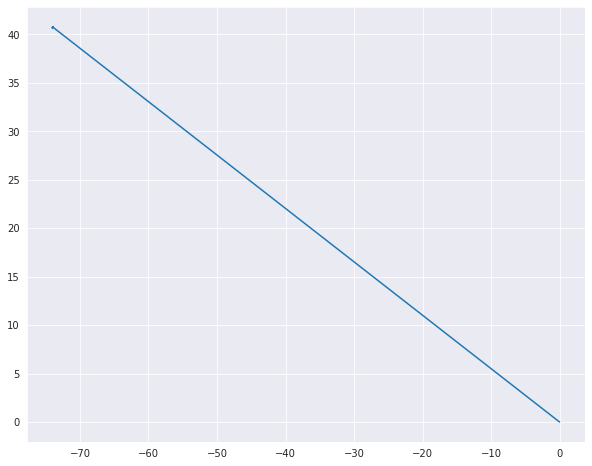

In [48]:
def showrides(df, numlines):
    lats = []
    lons = []
    for iter, row in df[:numlines].iterrows():
        lons.append(row['pickup_longitude'])
        lons.append(row['dropoff_longitude'])
        lons.append(None)
        lats.append(row['pickup_latitude'])
        lats.append(row['dropoff_latitude'])
        lats.append(None)
        
    sns.set_style("darkgrid")
    plt.figure(figsize=(10,8))
    plt.plot(lons, lats)
    
showrides(trips, 10)

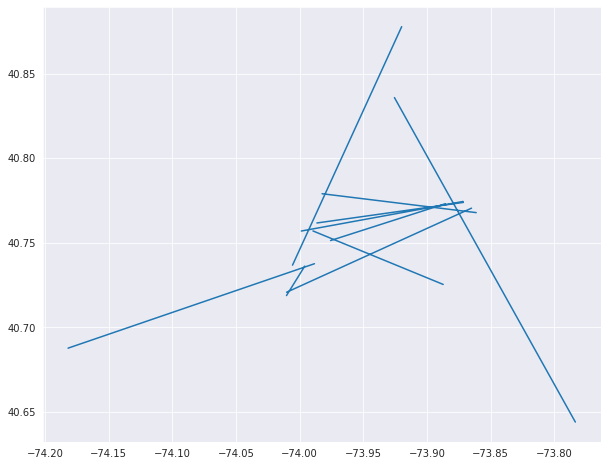

In [50]:
showrides(tollrides, 10)

# Quality control and other preprocessing

We need to some clean-up of the data:

1. New York city longitudes are around -74 and latitudes are around 41.
2. We shouldn't have zero passengers.
3. Clean up the total_amount column to reflect only fare_amount and tolls_amount, and then remove those two columns.
4. Before the ride starts, we'll know the pickup and dropoff locations, but not the trip distance (that depends on the route taken), so remove it from the ML dataset
5. Discard the timestamp

In [51]:
def preprocess(trips_in):
    trips = trips_in.copy(deep=True)
    trips.fare_amount = trips.fare_amount + trips.tolls_amount
    del trips['tolls_amount']
    del trips['total_amount']
    del trips['trip_distance']
    del trips['pickup_datetime']
    qc = np.all([\
                 trips['pickup_longitude'] > -78, \
                 trips['pickup_longitude'] < -70, \
                 trips['dropoff_longitude'] > -78, \
                 trips['dropoff_longitude'] < -70, \
                 trips['pickup_latitude'] > 37, \
                 trips['pickup_latitude'] < 45, \
                 trips['dropoff_latitude'] > 37, \
                 trips['dropoff_latitude'] < 45, \
                 trips['passenger_count'] > 0,
                ], axis=0)
    return trips[qc]

tripsqc = preprocess(trips)
tripsqc.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,10476.000000,10476.000000,10476.000000,10476.000000,10476.000000,10476.000000
mean,-73.975206,40.751526,-73.974373,40.751199,1.653303,11.349003
std,0.038547,0.029187,0.039086,0.033147,1.278827,9.878630
min,-74.258183,40.452290,-74.260472,40.417750,1.000000,2.500000
25%,-73.992336,40.737600,-73.991739,40.735904,1.000000,6.000000
50%,-73.982090,40.754020,-73.980780,40.753597,1.000000,8.500000
75%,-73.968517,40.767774,-73.965851,40.767921,2.000000,12.500000
max,-73.137393,41.366138,-73.137393,41.366138,6.000000,179.000000


In [52]:
# Create ML datasets
shuffled = tripsqc.sample(frac=1)
trainsize = int(len(shuffled['fare_amount']) * 0.7)
validsize = int(len(shuffled['fare_amount']) * 0.15)

df_train = shuffled.iloc[:trainsize, :]
df_valid = shuffled.iloc[trainsize:(trainsize+validsize), :]
df_test = shuffled.iloc[(trainsize+validsize):, :]

In [53]:
df_train.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,7333.000000,7333.000000,7333.000000,7333.000000,7333.000000,7333.000000
mean,-73.975361,40.751629,-73.974853,40.751170,1.648166,11.363490
std,0.037534,0.028255,0.036482,0.031638,1.278268,9.960597
min,-74.258183,40.608573,-74.260472,40.561076,1.000000,2.500000
25%,-73.992300,40.737389,-73.991768,40.736013,1.000000,6.000000
50%,-73.982158,40.754199,-73.980827,40.753391,1.000000,8.500000
75%,-73.968652,40.768000,-73.966060,40.768012,2.000000,12.500000
max,-73.137393,41.366138,-73.137393,41.366138,6.000000,179.000000


In [54]:
df_valid.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,1571.000000,1571.000000,1571.000000,1571.000000,1571.000000,1571.000000
mean,-73.975419,40.751642,-73.974137,40.750290,1.695099,11.111528
std,0.034676,0.026919,0.038640,0.031258,1.314532,9.598556
min,-74.187541,40.452290,-74.187541,40.417750,1.000000,2.500000
25%,-73.991994,40.739061,-73.991979,40.736562,1.000000,6.000000
50%,-73.982019,40.754512,-73.981168,40.753475,1.000000,8.500000
75%,-73.968493,40.766931,-73.966323,40.766010,2.000000,12.500000
max,-73.695303,40.854213,-73.501985,40.898810,6.000000,93.750000


In [55]:
def to_csv(df, filename):
    outdf = df.copy(deep=False)
    outdf.loc[:, 'key'] = np.arange(0, len(outdf))  # rownumber as key
    # reorder columns so that target is first column
    cols = outdf.columns.tolist()
    cols.remove('fare_amount')
    cols.insert(0, 'fare_amount')
    print(cols)  # new order of columns
    outdf = outdf[cols]
    outdf.to_csv(filename, header=False, index_label=False, index=False)
    
to_csv(df_train, 'taxi-train.csv')
to_csv(df_valid, 'taxi-valid.csv')
to_csv(df_test, 'taxi-test.csv')

['fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'key']
['fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'key']
['fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'key']


In [58]:
# Verify that datasets exist
!ls -l *.csv

-rw-r--r-- 1 vadzim vadzim  85183 Aug 19 08:13 taxi-test.csv
-rw-r--r-- 1 vadzim vadzim 403692 Aug 19 08:13 taxi-train.csv
-rw-r--r-- 1 vadzim vadzim  85460 Aug 19 08:13 taxi-valid.csv


In [59]:
!head -10 taxi-valid.csv

3.7,-73.99999,40.720608,-73.99681,40.72317,5,0
57.33,-73.963464,40.768656,-73.776288,40.645368,1,1
19.3,-74.010395,40.729794,-73.975179,40.718659,2,2
14.1,-73.97986,40.755059,-74.011913,40.70829,1,3
6.1,-73.988887,40.723109,-74.004381,40.707213,1,4
8.9,-73.968943,40.770078,-73.991142,40.739801,1,5
10.5,-73.788347,40.64145,-73.792922,40.678557,1,6
33.0,-73.995335,40.72167,-73.967223,40.756887,1,7
9.7,-73.975303,40.733033,-74.00586,40.711577,1,8
7.0,-73.962353,40.778972,-73.974025,40.762737,3,9


# Benchmark 
Before we start building complex ML models, it is a good idea to come up with a very simple model and use that as a benchmark.

My model is going to be to simply divide the mean fare_amount by the mean trip_distance to come up with a rate and use that to predict. Let's compute the RMSE of such a model.

In [63]:
def distance_between(lat1, lon1, lat2, lon2):
    # harvesine formula to compute distance "as the crow flies". 
    # Taxis can't fly of course.
    dist = np.degrees(np.arccos(np.minimum(1,np.sin(np.radians(lat1)) * np.sin(np.radians(lat2)) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.cos(np.radians(lon2 - lon1))))) * 60 * 1.515 * 1.609344
    return dist

def estimate_distance(df):
    return distance_between(df['pickuplat'], df['pickuplon'], df['dropofflat'], df['dropofflon'])

def compute_rmse(actual, predicted):
    return np.sqrt(np.mean((actual-predicted) ** 2))

def print_rmse(df, rate, name):
    print("{1} RMSE = {0}".format(compute_rmse(df['fare_amount'], rate*estimate_distance(df)), name))
    
FEATURES = ['pickuplon', 'pickuplat', 'dropofflon', 'dropofflat', 'passengers']
TARGET = 'fare_amount'
columns = list([TARGET])
columns.extend(FEATURES)  # in CSV, target is the first column, after the features
columns.append('key')
df_train = pd.read_csv('taxi-train.csv', header=None, names=columns)
df_valid = pd.read_csv('taxi-valid.csv', header=None, names=columns)
df_test = pd.read_csv('taxi-test.csv', header=None, names=columns)
rate = df_train['fare_amount'].mean() / estimate_distance(df_train).mean()
print("Rate = ${0}/km".format(rate))
print_rmse(df_train, rate, 'Train')
print_rmse(df_valid, rate, 'Valid')
print_rmse(df_test, rate, 'Test')

Rate = $2.5970699281693173/km
Train RMSE = 7.444026940071098
Valid RMSE = 6.017883417179004
Test RMSE = 9.478103304580667


In [64]:
# Benchmark on same dataset
def create_query(phase, EVERY_N):
    """
    pahse: 1=train 2=valid
    """
    base_query = """
SELECT
  (tolls_amount + fare_amount) AS fare_amount,
  CONCAT(CAST(pickup_datetime AS STRING), CAST(pickup_longitude AS STRING), CAST(pickup_latitude AS STRING), CAST(dropoff_latitude AS STRING), CAST(dropoff_longitude AS STRING)) AS key,
  EXTRACT(DAYOFWEEK FROM pickup_datetime)*1.0 AS dayofweek,
  EXTRACT(HOUR FROM pickup_datetime)*1.0 AS hourofday,
  pickup_longitude AS pickuplon,
  pickup_latitude AS pickuplat,
  dropoff_longitude AS dropofflon,
  dropoff_latitude AS dropofflat,
  passenger_count*1.0 AS passengers
FROM
  `nyc-tlc.yellow.trips`
WHERE
  trip_distance > 0
  AND fare_amount >= 2.5
  AND pickup_longitude > -78
  AND pickup_longitude < -70
  AND dropoff_longitude > -78
  AND dropoff_longitude < -70
  AND pickup_latitude > 37
  AND pickup_latitude < 45
  AND dropoff_latitude > 37
  AND dropoff_latitude < 45
  AND passenger_count > 0
"""
    
    if EVERY_N == None:
        if phase < 2:
            # training
            query = "{0} AND ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), 4)) < 2".format(base_query)
        else:
            query = "{0} AND ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), 4)) = {1}".format(base_query, phase)
    else:
            query = "{0} AND ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), {1})) = {2}".format(base_query, EVERY_N, phase)
    
    return query

query = create_query(2, 100000)
df_valid = client.query(query).to_dataframe()
print_rmse(df_valid, 2.56, 'Final Validation Set')

Final Validation Set RMSE = 7.415876616638181
